In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import ghalton
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from utils import clean,to_radian,hann,res_to_rad,ax_to_w,rep_to_angle
from rotation_2d import rot_cost_func, imrotate
from rotation_3d import rot_cost_func_3d,tricubic_derivatives,tricubic_interp
from visualize import plot_cost_func, plot_cost_func_t, plot_volume
from cost_functions import cf_ssd
from Gauss_Newton import sphere_mask,fourier_filter
from conversion import angles_from_q

In [4]:
oct13_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_10.p','rb'))
oct13_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_8.p','rb'))
oct13_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_6_4.p','rb'))

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Sept_23_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


In [6]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'z'
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

# Get two volumes to register
testVol1 = fourier_filter(oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)],rad)
testVol2 = fourier_filter(oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)],rad)
s0,s1,s2 = testVol1.shape

testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

vol1_dervs = tricubic_derivatives(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

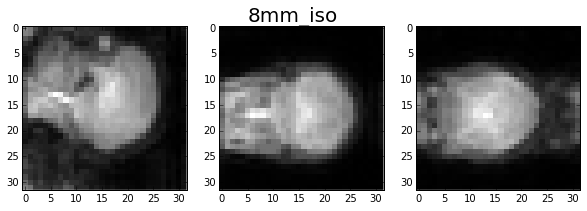

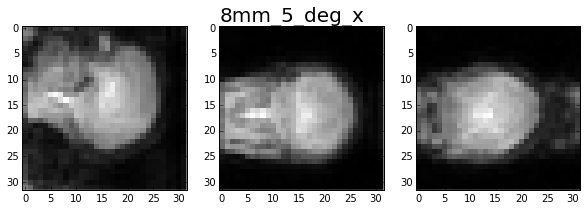

In [7]:
plot_volume(testVol1,'8mm','iso')
plot_volume(testVol2,'8mm','5_deg_x')

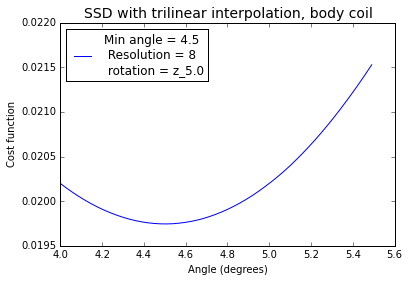

CPU times: user 1 s, sys: 123 ms, total: 1.12 s
Wall time: 1.12 s


In [8]:
%%time
# Register with trilinear interpolation
thetas = np.arange(4.0,5.5,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(testVol1_masked, testVol2_masked, thetas, wx,wy,wz,xx,yy,zz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'trilinear','%s_5.0'%rot_ax, 'body',lw=1)
plt.show()

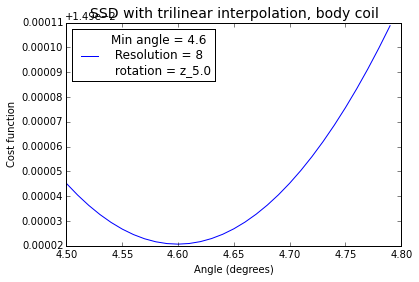

CPU times: user 19.5 s, sys: 157 ms, total: 19.6 s
Wall time: 19.7 s


In [9]:
%%time
# Register with tricubic interpolation
thetas = np.arange(4.5,4.8,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(testVol1_masked, testVol2_masked, thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'trilinear','%s_5.0'%rot_ax, 'body',lw=1)
plt.show()

In [10]:
from Bessel_Interp import generate_halton_points,circle_mask_points,bessel_rotate_arbitrary_points
from rotation_3d import volrotate_trilinear,volrotate_tricubic,tricubic_interp_1d

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


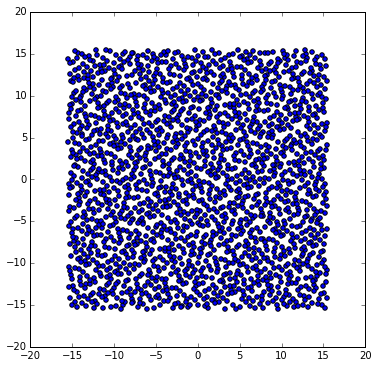

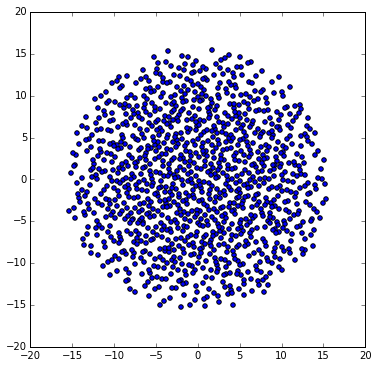

In [11]:
N = 1000
pts = generate_halton_points(N * 2, 3, len(testVol1) - 1)
pts_masked = circle_mask_points(pts,rad)
plt.figure(figsize=[6,6])
plt.scatter(pts[:,0],pts[:,1])
plt.show()
plt.figure(figsize=[6,6])
plt.scatter(pts_masked[:,0],pts_masked[:,1])
plt.show()

In [12]:
%%time
## Using unmasked volume and masked points
# Get a set of random points
dest_x,dest_y,dest_z = pts[:,0]+15.5,pts[:,1]+15.5,pts[:,2]+15.5

# interpolate the points using trilinear interpolation
vol1_pts_org_linear = volrotate_trilinear(testVol1,0,wx,wy,wz,dest_x,dest_y,dest_z)
vol2_pts_org_linear = volrotate_trilinear(testVol2,0,wx,wy,wz,dest_x,dest_y,dest_z)

# interpolate the points using tricubic interpolation
vol1_tricubic_coeffs = tricubic_derivatives(testVol1)
vol1_pts_org_cubic = volrotate_tricubic(testVol1.shape, vol1_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

vol2_tricubic_coeffs = tricubic_derivatives(testVol2)
vol2_pts_org_cubic = volrotate_tricubic(testVol2.shape, vol2_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

CPU times: user 34.1 s, sys: 394 ms, total: 34.5 s
Wall time: 35.2 s


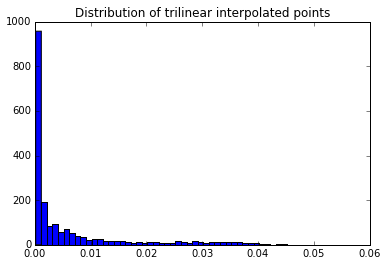

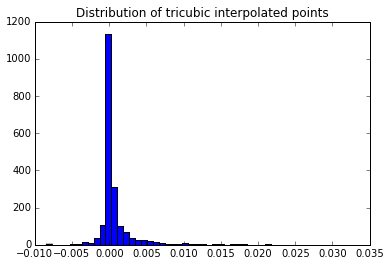

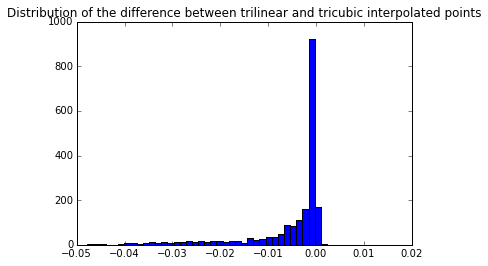

In [13]:
# without mask
plt.hist(vol1_pts_org_linear,bins = 50)
plt.title('Distribution of trilinear interpolated points')
plt.show()
plt.hist(vol1_pts_org_cubic,bins = 50)
plt.title('Distribution of tricubic interpolated points')
plt.show()
plt.hist(vol1_pts_org_cubic-vol1_pts_org_linear,bins = 50)
plt.title('Distribution of the difference between trilinear and tricubic interpolated points')
plt.show()

In [14]:
%%time
## Using masked volume and masked points
# Get a set of random points
dest_x,dest_y,dest_z = pts_masked[:,0]+15.5,pts_masked[:,1]+15.5,pts_masked[:,2]+15.5

# interpolate the points using trilinear interpolation
vol1_pts_org_linear = volrotate_trilinear(testVol1_masked,0,wx,wy,wz,dest_x,dest_y,dest_z)
vol2_pts_org_linear = volrotate_trilinear(testVol2_masked,0,wx,wy,wz,dest_x,dest_y,dest_z)

# interpolate the points using tricubic interpolation
vol1_tricubic_coeffs = tricubic_derivatives(testVol1_masked)
vol1_pts_org_cubic = volrotate_tricubic(testVol1_masked.shape, vol1_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

vol2_tricubic_coeffs = tricubic_derivatives(testVol2_masked)
vol2_pts_org_cubic = volrotate_tricubic(testVol2_masked.shape, vol2_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

pickle.dump((vol1_pts_org_linear,vol1_pts_org_cubic),open('interp_original.p','wb'))

CPU times: user 34.5 s, sys: 234 ms, total: 34.8 s
Wall time: 35 s


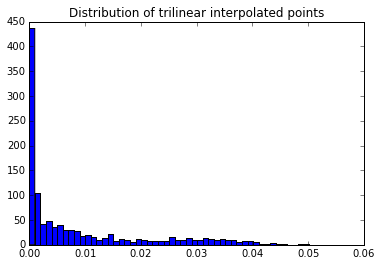

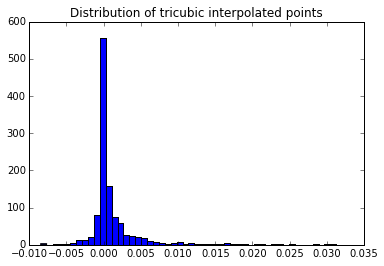

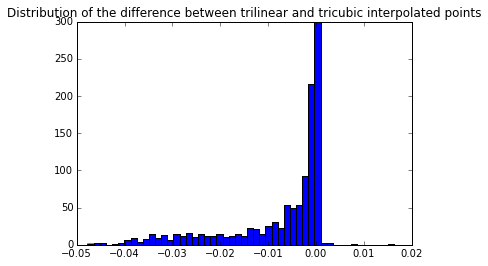

In [15]:
# with mask
plt.hist(vol1_pts_org_linear,bins = 50)
plt.title('Distribution of trilinear interpolated points')
plt.show()
plt.hist(vol1_pts_org_cubic,bins = 50)
plt.title('Distribution of tricubic interpolated points')
plt.show()
plt.hist(vol1_pts_org_cubic-vol1_pts_org_linear,bins = 50)
plt.title('Distribution of the difference between trilinear and tricubic interpolated points')
plt.show()

In [39]:
# Upsample to 64
s0,s1,s2 = testVol1.shape
x = np.linspace(0, s1-1, s1*2)
y = np.linspace(0, s0-1, s0*2)
z = np.linspace(0, s2-1, s2*2)
dest_x, dest_y, dest_z = np.meshgrid(x,y,z)

volume_shape = testVol1.shape
testVol1_upsampled = np.empty(dest_x.shape)
for i in xrange(dest_x.shape[0]):
    testVol1_upsampled[i,:,:] = tricubic_interp(volume_shape,vol1_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 
    
testVol2_upsampled = np.empty(dest_x.shape)
for i in xrange(dest_x.shape[0]):
    testVol2_upsampled[i,:,:] = tricubic_interp(volume_shape,vol2_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 

rad = testVol1_upsampled.shape[0]/2
testVol1_upsampled_masked = sphere_mask(testVol1_upsampled,rad)
testVol2_upsampled_masked = sphere_mask(testVol2_upsampled,rad)

s0,s1,s2 = testVol1_upsampled.shape
x = np.linspace(0, s1-1, s1)
y = np.linspace(0, s0-1, s0)
z = np.linspace(0, s2-1, s2)

xx_upsampled, yy_upsampled, zz_upsampled = np.meshgrid(x,y,z)

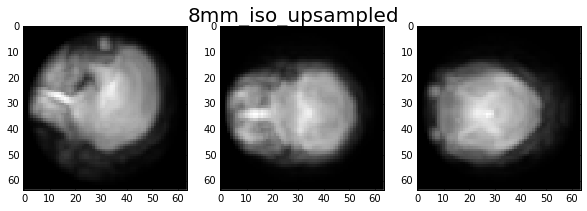

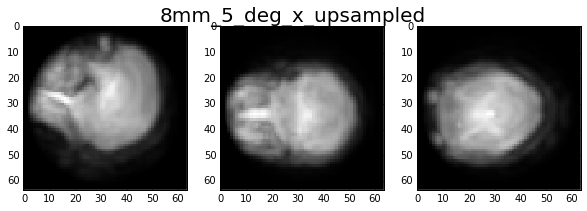

In [41]:
plot_volume(testVol1_upsampled_masked,'8mm','iso_upsampled')
plot_volume(testVol2_upsampled_masked,'8mm','5_deg_x_upsampled')

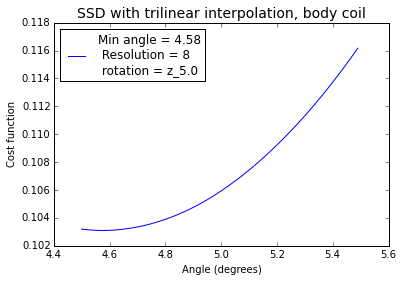

CPU times: user 7.2 s, sys: 1.23 s, total: 8.43 s
Wall time: 8.53 s


In [42]:
%%time
# Register with trilinear interpolation
thetas = np.arange(4.5,5.5,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(testVol1_upsampled_masked, testVol2_upsampled_masked, thetas, wx,wy,wz,
                        xx_upsampled, yy_upsampled, zz_upsampled, interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'trilinear','%s_5.0'%rot_ax, 'body',lw=1)
plt.show()

In [43]:
%%time
## Using masked volume and masked points
# Get a set of random points
dest_x,dest_y,dest_z = pts_masked[:,0]*2+15.5,pts_masked[:,1]*2+15.5,pts_masked[:,2]*2+15.5

# interpolate the points using trilinear interpolation
vol1_pts_2x_linear = volrotate_trilinear(testVol1_upsampled_masked,0,wx,wy,wz,dest_x,dest_y,dest_z)
vol2_pts_2x_linear = volrotate_trilinear(testVol2_upsampled_masked,0,wx,wy,wz,dest_x,dest_y,dest_z)

# interpolate the points using tricubic interpolation
vol1_tricubic_coeffs = tricubic_derivatives(testVol1_upsampled_masked)
vol1_pts_2x_cubic = volrotate_tricubic(testVol1_upsampled_masked.shape, vol1_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

vol2_tricubic_coeffs = tricubic_derivatives(testVol2_upsampled_masked)
vol2_pts_2x_cubic = volrotate_tricubic(testVol2_upsampled_masked.shape, vol2_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

pickle.dump((vol1_pts_2x_linear,vol2_pts_2x_linear,vol1_pts_2x_cubic,vol2_pts_2x_cubic),open('interp_2x.p','wb'))

CPU times: user 1min 59s, sys: 1.61 s, total: 2min 1s
Wall time: 2min 3s


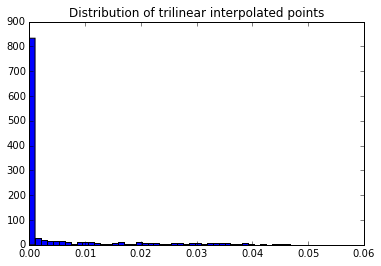

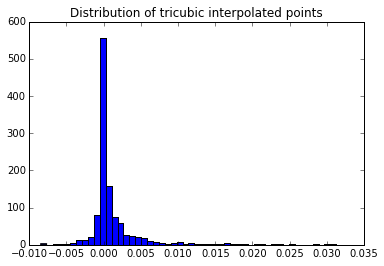

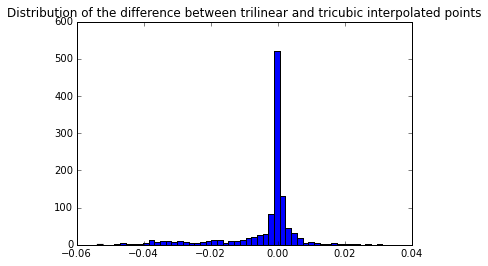

In [57]:
# with mask
plt.hist(vol1_pts_2x_linear,bins = 50)
plt.title('Distribution of trilinear interpolated points')
plt.show()
plt.hist(vol1_pts_org_cubic,bins = 50)
plt.title('Distribution of tricubic interpolated points')
plt.show()
plt.hist(vol1_pts_org_cubic-vol1_pts_2x_linear,bins = 50)
plt.title('Distribution of the difference between trilinear and tricubic interpolated points')
plt.show()

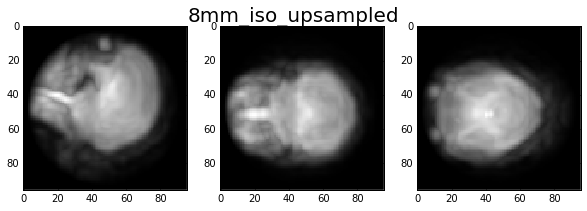

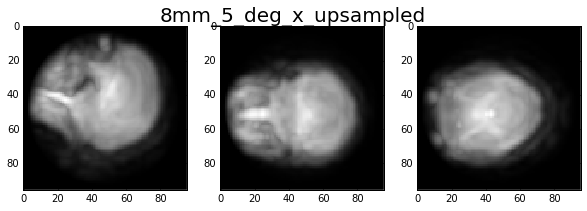

In [45]:
# Upsample to 32*3
s0,s1,s2 = testVol1.shape
x = np.linspace(0, s1-1, s1*3)
y = np.linspace(0, s0-1, s0*3)
z = np.linspace(0, s2-1, s2*3)
dest_x, dest_y, dest_z = np.meshgrid(x,y,z)

volume_shape = testVol1.shape
testVol1_upsampled = np.empty(dest_x.shape)
for i in xrange(dest_x.shape[0]):
    testVol1_upsampled[i,:,:] = tricubic_interp(volume_shape,vol1_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 
    
testVol2_upsampled = np.empty(dest_x.shape)
for i in xrange(dest_x.shape[0]):
    testVol2_upsampled[i,:,:] = tricubic_interp(volume_shape,vol2_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 

rad = testVol1_upsampled.shape[0]/2
testVol1_upsampled_masked = sphere_mask(testVol1_upsampled,rad)
testVol2_upsampled_masked = sphere_mask(testVol2_upsampled,rad)

s0,s1,s2 = testVol1_upsampled.shape
x = np.linspace(0, s1-1, s1)
y = np.linspace(0, s0-1, s0)
z = np.linspace(0, s2-1, s2)
xx_upsampled, yy_upsampled, zz_upsampled = np.meshgrid(x,y,z)

plot_volume(testVol1_upsampled_masked,'8mm','iso_upsampled')
plot_volume(testVol2_upsampled_masked,'8mm','5_deg_x_upsampled')

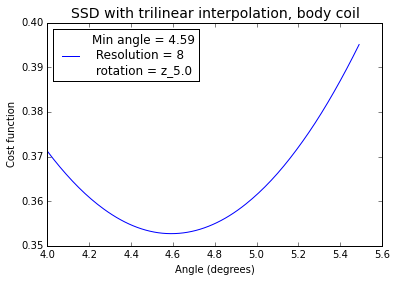

CPU times: user 38.2 s, sys: 13.6 s, total: 51.8 s
Wall time: 52.9 s


In [46]:
%%time
# Register with trilinear interpolation
thetas = np.arange(4.0,5.5,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(testVol1_upsampled_masked, testVol2_upsampled_masked, thetas, wx,wy,wz,
                        xx_upsampled, yy_upsampled, zz_upsampled, interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'trilinear','%s_5.0'%rot_ax, 'body',lw=1)
plt.show()

In [47]:
%%time
## Using masked volume and masked points
# Get a set of random points
dest_x,dest_y,dest_z = pts_masked[:,0]*3+15.5,pts_masked[:,1]*3+15.5,pts_masked[:,2]*3+15.5

# interpolate the points using trilinear interpolation
vol1_pts_3x_linear = volrotate_trilinear(testVol1_upsampled_masked,0,wx,wy,wz,dest_x,dest_y,dest_z)
vol2_pts_3x_linear = volrotate_trilinear(testVol2_upsampled_masked,0,wx,wy,wz,dest_x,dest_y,dest_z)

# interpolate the points using tricubic interpolation
vol1_tricubic_coeffs = tricubic_derivatives(testVol1_upsampled_masked)
vol1_pts_3x_cubic = volrotate_tricubic(testVol1_upsampled_masked.shape, vol1_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

vol2_tricubic_coeffs = tricubic_derivatives(testVol2_upsampled_masked)
vol2_pts_3x_cubic = volrotate_tricubic(testVol2_upsampled_masked.shape, vol2_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

pickle.dump((vol1_pts_3x_linear,vol2_pts_3x_linear,vol1_pts_3x_cubic,vol2_pts_3x_cubic),open('interp_3x.p','wb'))

CPU times: user 4min 34s, sys: 2.41 s, total: 4min 37s
Wall time: 4min 39s


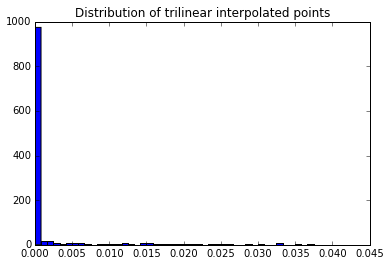

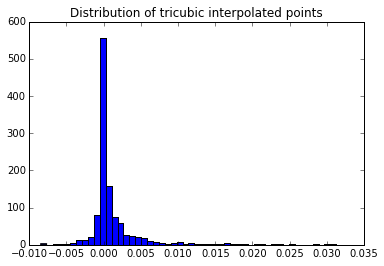

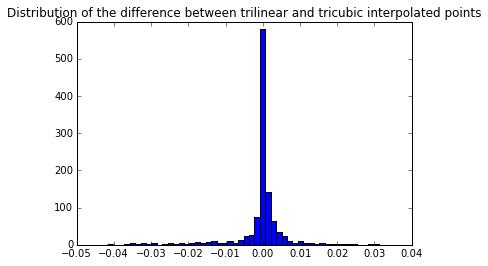

In [58]:
# with mask
plt.hist(vol1_pts_3x_linear,bins = 50)
plt.title('Distribution of trilinear interpolated points')
plt.show()
plt.hist(vol1_pts_org_cubic,bins = 50)
plt.title('Distribution of tricubic interpolated points')
plt.show()
plt.hist(vol1_pts_org_cubic-vol1_pts_3x_linear,bins = 50)
plt.title('Distribution of the difference between trilinear and tricubic interpolated points')
plt.show()

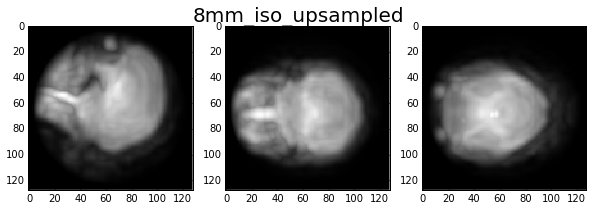

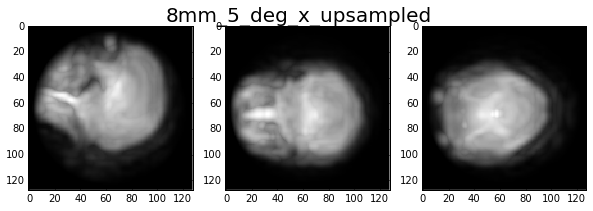

In [49]:
# Upsample to 32*4
s0,s1,s2 = testVol1.shape
x = np.linspace(0, s1-1, s1*4)
y = np.linspace(0, s0-1, s0*4)
z = np.linspace(0, s2-1, s2*4)
dest_x, dest_y, dest_z = np.meshgrid(x,y,z)

volume_shape = testVol1.shape
testVol1_upsampled = np.empty(dest_x.shape)
for i in xrange(dest_x.shape[0]):
    testVol1_upsampled[i,:,:] = tricubic_interp(volume_shape,vol1_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 
    
testVol2_upsampled = np.empty(dest_x.shape)
for i in xrange(dest_x.shape[0]):
    testVol2_upsampled[i,:,:] = tricubic_interp(volume_shape,vol2_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 

rad = testVol1_upsampled.shape[0]/2
testVol1_upsampled_masked = sphere_mask(testVol1_upsampled,rad)
testVol2_upsampled_masked = sphere_mask(testVol2_upsampled,rad)

s0,s1,s2 = testVol1_upsampled.shape
x = np.linspace(0, s1-1, s1)
y = np.linspace(0, s0-1, s0)
z = np.linspace(0, s2-1, s2)
xx_upsampled, yy_upsampled, zz_upsampled = np.meshgrid(x,y,z)

plot_volume(testVol1_upsampled_masked,'8mm','iso_upsampled')
plot_volume(testVol2_upsampled_masked,'8mm','5_deg_x_upsampled')

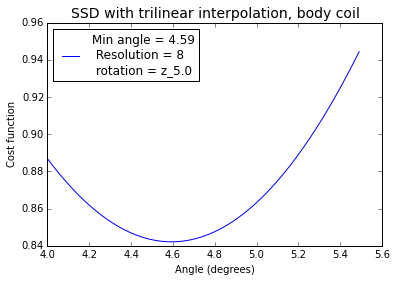

CPU times: user 1min 24s, sys: 39.1 s, total: 2min 3s
Wall time: 2min 3s


In [50]:
%%time
# Register with trilinear interpolation
thetas = np.arange(4.0,5.5,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(testVol1_upsampled_masked, testVol2_upsampled_masked, thetas, wx,wy,wz,
                        xx_upsampled, yy_upsampled, zz_upsampled, interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'trilinear','%s_5.0'%rot_ax, 'body',lw=1)
plt.show()

In [51]:
%%time
## Using masked volume and masked points
# Get a set of random points
dest_x,dest_y,dest_z = pts_masked[:,0]*4+15.5,pts_masked[:,1]*4+15.5,pts_masked[:,2]*4+15.5

# interpolate the points using trilinear interpolation
vol1_pts_4x_linear = volrotate_trilinear(testVol1_upsampled_masked,0,wx,wy,wz,dest_x,dest_y,dest_z)
vol2_pts_4x_linear = volrotate_trilinear(testVol2_upsampled_masked,0,wx,wy,wz,dest_x,dest_y,dest_z)

# interpolate the points using tricubic interpolation
vol1_tricubic_coeffs = tricubic_derivatives(testVol1_upsampled_masked)
vol1_pts_4x_cubic = volrotate_tricubic(testVol1_upsampled_masked.shape, vol1_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

vol2_tricubic_coeffs = tricubic_derivatives(testVol2_upsampled_masked)
vol2_pts_4x_cubic = volrotate_tricubic(testVol2_upsampled_masked.shape, vol2_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

pickle.dump((vol1_pts_4x_linear,vol2_pts_4x_linear,vol1_pts_4x_cubic,vol2_pts_4x_cubic),open('interp_4x.p','wb'))

CPU times: user 8min 50s, sys: 3.67 s, total: 8min 54s
Wall time: 8min 55s


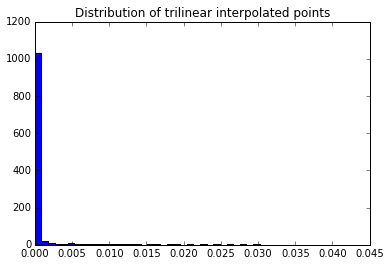

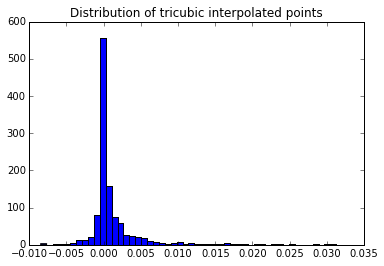

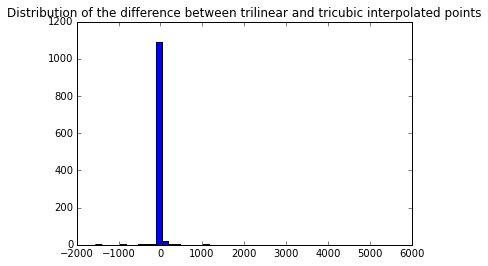

In [62]:
# with mask
plt.hist(vol1_pts_4x_linear,bins = 50)
plt.title('Distribution of trilinear interpolated points')
plt.show()
plt.hist(vol1_pts_org_cubic,bins = 50)
plt.title('Distribution of tricubic interpolated points')
plt.show()
plt.hist((vol1_pts_org_cubic-vol1_pts_4x_linear)/vol1_pts_org_cubic,bins = 50)
plt.title('Distribution of the difference between trilinear and tricubic interpolated points')
plt.show()

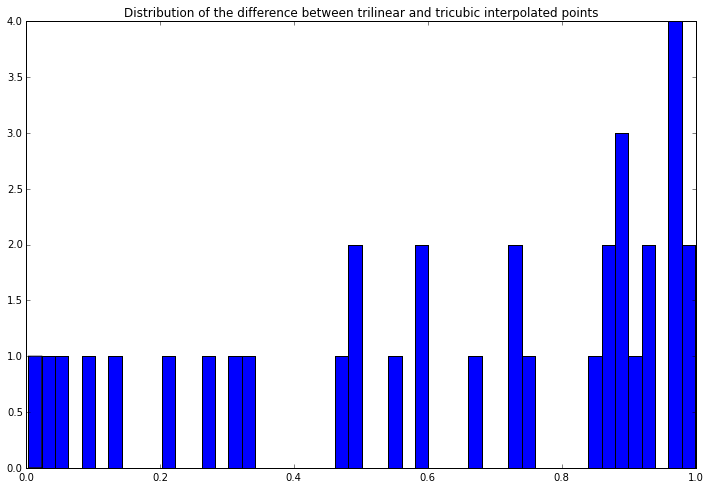

In [66]:
tmp  =abs((vol1_pts_org_cubic-vol1_pts_4x_linear)/vol1_pts_org_cubic)
plt.figure(figsize=[12,8])
plt.hist(tmp[tmp<1],bins = 50)
plt.title('Distribution of the difference between trilinear and tricubic interpolated points')
plt.show()

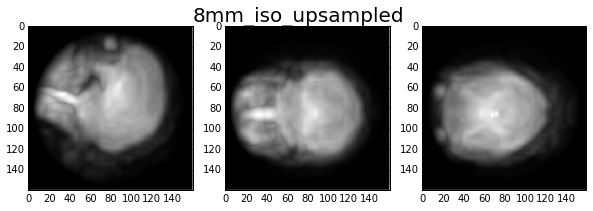

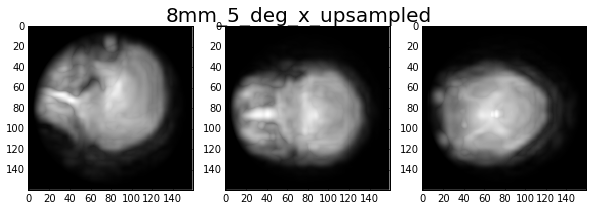

In [53]:
# Upsample to 32*5
s0,s1,s2 = testVol1.shape
x = np.linspace(0, s1-1, s1*5)
y = np.linspace(0, s0-1, s0*5)
z = np.linspace(0, s2-1, s2*5)
dest_x, dest_y, dest_z = np.meshgrid(x,y,z)

volume_shape = testVol1.shape
testVol1_upsampled = np.empty(dest_x.shape)
for i in xrange(dest_x.shape[0]):
    testVol1_upsampled[i,:,:] = tricubic_interp(volume_shape,vol1_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 
    
testVol2_upsampled = np.empty(dest_x.shape)
for i in xrange(dest_x.shape[0]):
    testVol2_upsampled[i,:,:] = tricubic_interp(volume_shape,vol2_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 

rad = testVol1_upsampled.shape[0]/2
testVol1_upsampled_masked = sphere_mask(testVol1_upsampled,rad)
testVol2_upsampled_masked = sphere_mask(testVol2_upsampled,rad)

s0,s1,s2 = testVol1_upsampled.shape
x = np.linspace(0, s1-1, s1)
y = np.linspace(0, s0-1, s0)
z = np.linspace(0, s2-1, s2)
xx_upsampled, yy_upsampled, zz_upsampled = np.meshgrid(x,y,z)

plot_volume(testVol1_upsampled_masked,'8mm','iso_upsampled')
plot_volume(testVol2_upsampled_masked,'8mm','5_deg_x_upsampled')

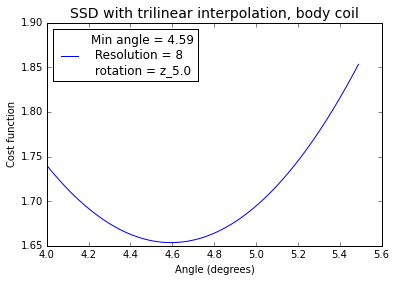

CPU times: user 2min 45s, sys: 1min 19s, total: 4min 5s
Wall time: 4min 11s


In [54]:
%%time
# Register with trilinear interpolation
thetas = np.arange(4.0,5.5,0.01)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(testVol1_upsampled_masked, testVol2_upsampled_masked, thetas, wx,wy,wz,
                        xx_upsampled, yy_upsampled, zz_upsampled, interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'trilinear','%s_5.0'%rot_ax, 'body',lw=1)
plt.show()

In [ ]:
%%time
## Using masked volume and masked points
# Get a set of random points
dest_x,dest_y,dest_z = pts_masked[:,0]*5+15.5,pts_masked[:,1]*5+15.5,pts_masked[:,2]*5+15.5

# interpolate the points using trilinear interpolation
vol1_pts_5x_linear = volrotate_trilinear(testVol1_upsampled_masked,0,wx,wy,wz,dest_x,dest_y,dest_z)
vol2_pts_5x_linear = volrotate_trilinear(testVol2_upsampled_masked,0,wx,wy,wz,dest_x,dest_y,dest_z)

# interpolate the points using tricubic interpolation
vol1_tricubic_coeffs = tricubic_derivatives(testVol1_upsampled_masked)
vol1_pts_5x_cubic = volrotate_tricubic(testVol1_upsampled_masked.shape, vol1_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

vol2_tricubic_coeffs = tricubic_derivatives(testVol2_upsampled_masked)
vol2_pts_5x_cubic = volrotate_tricubic(testVol2_upsampled_masked.shape, vol2_tricubic_coeffs, 0, wx,wy,wz,
                                        dest_x,dest_y,dest_z,True)

pickle.dump((vol1_pts_5x_linear,vol2_pts_5x_linear,vol1_pts_5x_cubic,vol2_pts_5x_cubic),open('interp_5x.p','wb'))

In [ ]:
# with mask
plt.hist(vol1_pts_5x_linear,bins = 50)
plt.title('Distribution of trilinear interpolated points')
plt.show()
plt.hist(vol1_pts_5x_cubic,bins = 50)
plt.title('Distribution of tricubic interpolated points')
plt.show()
plt.hist(vol1_pts_5x_cubic-vol1_pts_5x_linear,bins = 50)
plt.title('Distribution of the difference between trilinear and tricubic interpolated points')
plt.show()